In [56]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn 
import statistics

#### Обработчик данных

In [105]:
class PrepareDate():
    # в констуркоре определим методы обработки данных
    def __init__(self, df_output):
        self.df_output = df_output

    # расчет затрат
    # (количество топлива (http://newsruss.ru/doc/index.php/Расход_топлива_у_самолётов) * минуты  )
    # * стоимость топлива (https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/?id=7379) - 51 859
    #  для самолтатов  Boeing 737-300 - 40 кг/1 мин, Sukhoi Superjet-100 - 28 кг / 1 мин
    def calculatePetrol(self):
        self.df_output['petrol'] = 0
        self.df_output.loc[(self.df_output['plane_model'] == 'Boeing 737-300'), 'petrol'] = 40
        self.df_output.loc[(self.df_output['plane_model'] == 'Sukhoi Superjet-100'), 'petrol'] = 28

        self.df_output['cost_petrol'] = (self.df_output['petrol'] * self.df_output['duration_minutes']) / 1000 * 51859
        self.calcululateTotalCosts()

    # так как общих затрат я не нашел - буду исходить из процентого соотношения затрат (https://www.aex.ru/docs/1/2011/4/13/1323/)
    #  топливо - 20% (оно нам известно  - примем за константу)
    #  аэропортовые сборы, наземное обслуживание, аэронавигация  примем на 20% (равно типливу)
    #  лизинговые и таможенные платежи, расходы на обслуживание кредита примем на 20% (равно типливу)
    #  техническое обслуживание парка авиасудов примем на 10% (равно половину типливу)
    #  расходы на оплату труда пилотного состава на 10% (равно половину типливу)
    #  todo общиие затраты =  4 * (затраты топлива)
    def calcululateTotalCosts(self):
        self.df_output['Costs'] = 4 * self.df_output['cost_petrol']

    #  извлечение даты
    def foramedDate(self):
        self.df_output['date_departure'] = pd.to_datetime( self.df_output['date_departure'], format='%d-%m-%Y %H:%M:%S')
        self.df_output['day_of_week'] =  self.df_output['date_departure'].dt.dayofweek
        self.df_output['month'] =  self.df_output['date_departure'].dt.month

    #  извлечение разных метрик
    def calculateProfit(self):
        # общая прибыль = продажа билетов - затраы
        self.df_output['profit'] =  self.df_output['pass_summ'] - self.df_output['Costs']
        #  заполняемость мест в т.ч. бизнес и экном классов
        self.df_output['occupancy'] = self.df_output['pass_count'] / self.df_output['plane_count']
        self.df_output['occupancy_econom'] = self.df_output['pass_econom_count'] / self.df_output['plane_econom_count']
        self.df_output['occupancy_bisness'] = self.df_output['pass_bisiness_count'] / self.df_output['plane_bisiness_count']

         # доля продажи  бизнес и экном билетов от общей продажи билетов
        self.df_output['part_bisness'] = self.df_output['pass_bisiness_summ'] / self.df_output['pass_summ']
        self.df_output['part_econom'] = self.df_output['pass_econom_summ'] / self.df_output['pass_summ']

        # как один пассажир влияет на доходность / или на продажу билетов
        self.df_output['deposit_profit'] = (self.df_output['profit'] )/ self.df_output['pass_count']
        self.df_output['deposit'] = (self.df_output['pass_summ'] )/ self.df_output['pass_count']
        self.df_output['deposit_econom'] = (self.df_output['pass_econom_summ'] )/ self.df_output['pass_econom_count']
        self.df_output['deposit_bisness'] = (self.df_output['pass_bisiness_summ'] )/ self.df_output['pass_bisiness_count']


    def processData(self):
        self.calculatePetrol()
        self.foramedDate()
        self.calculateProfit()

        return self.df_output


# Загрузка данных:

In [106]:
data = pd.read_csv('data.csv')

df_object = PrepareDate(data)
df = df_object.processData()

In [81]:
df.sample(5)

,flight_id,date_departure,duration_minutes,departure_city,departure_lon,departure_lat,city,arrival_lon,arrival_lat,plane_model,...,profit,occupancy,occupancy_econom,occupancy_bisness,part_bisness,part_econom,deposit_profit,deposit,deposit_econom,deposit_bisness
3,136135,2017-02-01 10:08:00,100,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,848856.00,0.884615,0.881356,0.916667,0.239843,0.760157,7381.356522,14596.521739,12269.230769,36600.0
22,136209,2017-01-06 10:09:00,100,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,785456.00,0.861538,0.864407,0.833333,0.226597,0.773403,7013.000000,14421.428571,12247.058824,36600.0
80,136320,2017-02-19 10:05:00,100,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,714656.00,0.815385,0.813559,0.833333,0.236985,0.763015,6742.037736,14569.811321,12275.000000,36600.0
4,136936,2017-01-02 09:28:00,50,Anapa,37.347301,45.002102,Belgorod,36.590099,50.643799,Sukhoi Superjet-100,...,341989.60,0.845361,0.858824,0.750000,0.268975,0.731025,4170.604878,7712.195122,6332.876712,18900.0
78,136387,2017-01-19 10:08:00,99,Anapa,37.347301,45.002102,Moscow,37.414600,55.972599,Boeing 737-300,...,953553.44,0.930769,0.923729,1.000000,0.247437,0.752563,7880.606942,14669.421488,12255.045872,36600.0


***Количество рейсов:***


<AxesSubplot:ylabel='city'>

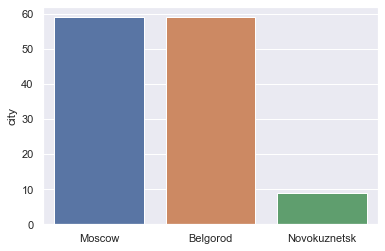

In [82]:
seaborn.barplot(x=df['city'].value_counts().index, y=df['city'].value_counts())

<AxesSubplot:ylabel='day_of_week'>

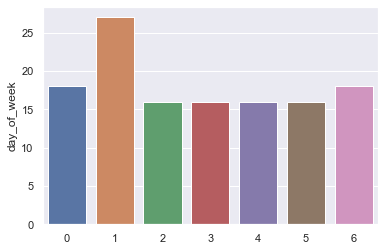

In [83]:
seaborn.barplot(x=df['day_of_week'].value_counts().index, y=df['day_of_week'].value_counts())

<AxesSubplot:ylabel='month'>

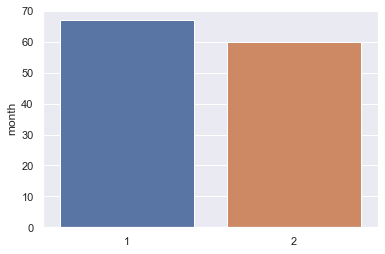

In [84]:
seaborn.barplot(x=df['month'].value_counts().index, y=df['month'].value_counts())

***Вывод:*** <br> Видно, что большинство рейсов в Москву и Белгород <br>
Количество рейсов по дням недели также примерно одинаково, кроме Вторника - рейсов больше! <br>
Также видно в декабре рейсов не было!

### Анализ направлений
Среднне время полета

<AxesSubplot:xlabel='city'>

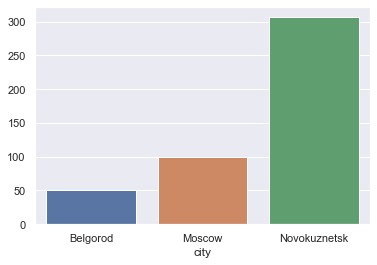

In [85]:
dff = df.groupby(['city'])['duration_minutes'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

In [86]:
dff = df.groupby('city')['plane_model'].unique()
dff

city
Belgorod        [Sukhoi Superjet-100]
Moscow               [Boeing 737-300]
Novokuznetsk         [Boeing 737-300]
Name: plane_model, dtype: object

### Таким образом для каждого города назначения летает только один тип самолета!

Среднняя стоимость билетов пассажиров  по городам: 

<AxesSubplot:xlabel='city'>

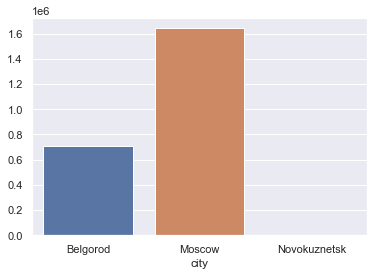

In [87]:
dff = df.groupby(['city'])['pass_summ'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

In [88]:
df[df['city'] == 'Novokuznetsk'][['pass_econom_summ', 'pass_bisiness_summ', 'pass_summ']]

,pass_econom_summ,pass_bisiness_summ,pass_summ
8,NaN,NaN,NaN
27,NaN,NaN,NaN
38,NaN,NaN,NaN
57,NaN,NaN,NaN
68,NaN,NaN,NaN
87,NaN,NaN,NaN
98,NaN,NaN,NaN
117,NaN,NaN,NaN
124,NaN,NaN,NaN


В датасете нет данных по рейсам в Novokuznetsk - ислючим данные из датасета. Так как нет данных по продажам билетов в это направление, есть затраты (оринтировочные), но нет данных по доходам , опиратся не на что - исключим данные из датасета.


In [89]:
df = df[df['city'] != 'Novokuznetsk'].copy()

### Анализ доходности рейсов (средняя заполняемость (бизнесс - эконом класс))
1.1 Средняя прибыль по рейсам

<AxesSubplot:xlabel='city'>

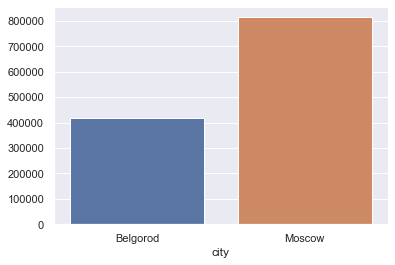

In [91]:
dff = df.groupby(['city'])['profit'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

1.2 Заполняемость рейса по пассажирам 

<AxesSubplot:xlabel='city'>

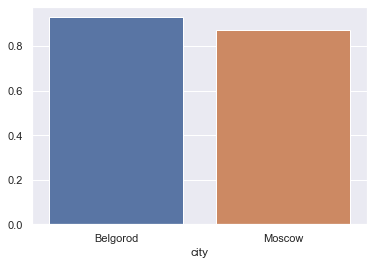

In [92]:
dff = df.groupby(['city'])['occupancy'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

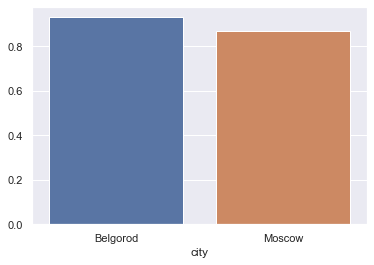

In [97]:
dff = df.groupby(['city'])['occupancy_econom'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

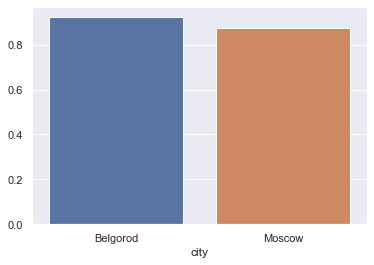

In [98]:
dff = df.groupby(['city'])['occupancy_bisness'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

1.3 Доля типов пассажирских классов в общую сумму прибыли

<AxesSubplot:xlabel='city'>

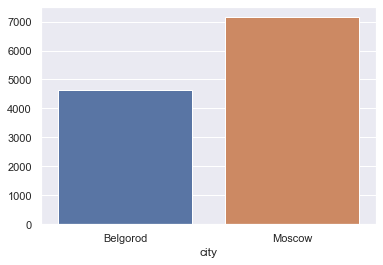

In [99]:
dff = df.groupby(['city'])['deposit_profit'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

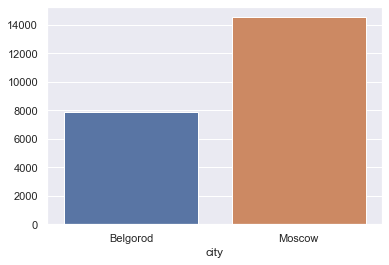

In [100]:
dff = df.groupby(['city'])['deposit'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

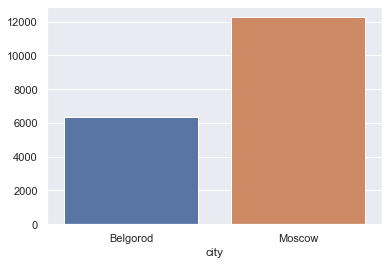

In [101]:
dff = df.groupby(['city'])['deposit_econom'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

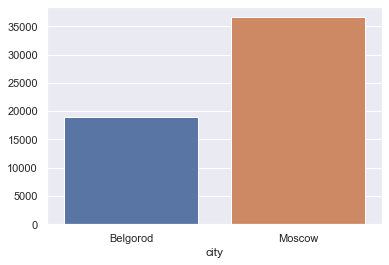

In [102]:
dff = df.groupby(['city'])['deposit_bisness'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

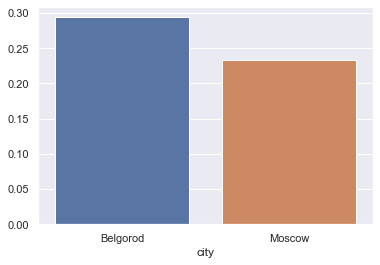

In [103]:
dff = df.groupby(['city'])['part_bisness'].mean()
seaborn.barplot(x=dff.index, y=dff.values)

<AxesSubplot:xlabel='city'>

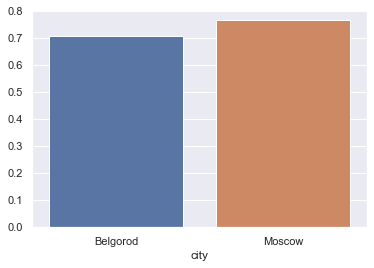

In [104]:
dff = df.groupby(['city'])['part_econom'].mean()
seaborn.barplot(x=dff.index, y=dff.values)